## Within subject statistics
AKA, Wilcoxon signed-rank tests

In [1]:
import mne
import numpy as np
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
from glob import glob
import csv
import h5py
from tqdm.notebook import tqdm
import sys
sys.path.append('../preprocessing/utils/')
import strf
from matplotlib import pyplot as plt
plt.style.use('seaborn')
from matplotlib import rcParams as rc
rc['pdf.fonttype'] = 42

In [2]:
# Change these path for running the notebook locally
eeg_data_path = '/path/to/dataset/' # downloadable from OSF: https://doi.org/10.17605/OSF.IO/FNRD9
git_path  = '/path/to/git/speaker_induced_suppression_EEG/'
# Where the output of train_linear_model.ipynb is saved. Run that first if you haven't already.
h5_path = '/path/to/h5/'

In [3]:
picks = ['F1','Fz','F2','FC1','FCz','FC2','C1','Cz','C2']
tmin,tmax = -1.5, 3.5
baseline=(None,0)
reject_thresh = 10 # SD
exclude = 'OP0020'
subjs = np.sort([s[-6:] for s in glob(f'{git_path}eventfiles/*') if 'OP0' in s and exclude not in s])

## Load ERP data

In [4]:
def interpolate_bads(subj,block,raw,git_path,eeg_data_path):
    '''
    CCA .vhdr files do not include bad channels, so this func interpolates them.
    The end result is each subject has a 64 channel raw arrray, which makes plotting easier
    Filter the data before running this!
    '''
    blockid = subj + '_' + block
    nsamps = len(raw)
    info = mne.io.read_raw_brainvision(f'{eeg_data_path}OP0001/OP0001_B1/OP0001_B1_cca.vhdr',
                                           preload=False,verbose=False).info
    ch_names = info['ch_names']
    bads = [c for c in ch_names if c not in raw.info['ch_names']]
    if len(bads) > 0:
        new_data = []
        for ch in ch_names:
            if ch in bads:
                print('Interpolating', ch)
                new_data.append(np.zeros((1,nsamps)))
            else:
                new_data.append(raw.get_data(picks=ch)[0])
        raw = mne.io.RawArray(np.vstack(new_data),info)
        raw.info['bads'] = bads
        raw.interpolate_bads()
    else:
        print(subj, 'has no bads.')
    return raw

In [5]:
raws, spkr_epochs, mic_epochs, spkr_resp, mic_resp = dict(), dict(), dict(), dict(), dict()
conditions = ['el','sh','all']
channels = ['spkr', 'mic']
conditions
subj_bar = tqdm(subjs)
for s in subj_bar:
    spkr_epochs[s], mic_epochs[s], spkr_resp[s], mic_resp[s] = dict(), dict(), dict(), dict()
    if s != 'OP0002':
        block = 'B1'
    else:
        block = 'B2'
    blockid = s + '_' + block
    raw_path = f'{eeg_data_path}{s}/{blockid}/{blockid}_cca.vhdr'
    raw = mne.io.read_raw_brainvision(raw_path,preload=True,verbose=False)
    raw.filter(l_freq=1,h_freq=30,verbose=False)
    raws[s] = interpolate_bads(s,block,raw,git_path,eeg_data_path)
    for ch in channels:
        spkr_epochs[s][ch], mic_epochs[s][ch], spkr_resp[s][ch], mic_resp[s][ch] = dict(), dict(), dict(), dict()
        for co in conditions:
            subj_bar.set_description(f'Epoching {s} {ch} {co}')
            if s in ['OP0015','OP0016']: # mtpl blocks
                events = []
                for b in ['B1','B2']: 
                    event_file = f'{git_path}eventfiles/{s}/{s}_{b}/{s}_{b}_{ch}_sn_{co}.txt'
                    if b == 'B2':
                        b2_fpath = raw_path = f'{eeg_data_path}{s}/{s}_B1/{s}_B1_downsampled.vhdr'
                        b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
                        block_shift = b2_raw.last_samp
                    else:
                        block_shift = 0
                    with open(event_file, 'r') as my_csv:
                        csvReader = csv.reader(my_csv, delimiter='\t')
                        for row in csvReader:
                            onset = int((float(row[0])*128)+block_shift)
                            offset = int((float(row[1])*128)+block_shift)
                            sn_id = int(row[2])
                            events.append([onset,offset,sn_id])
                events = np.array(events,dtype=int)
            else:
                event_file = f'{git_path}eventfiles/{s}/{blockid}/{blockid}_{ch}_sn_{co}.txt'
                events = []
                with open(event_file, 'r') as my_csv:
                    csvReader = csv.reader(my_csv, delimiter='\t')
                    for row in csvReader:
                        onset = int((float(row[0])*128))
                        offset = int((float(row[1])*128))
                        sn_id = int(row[2])
                        events.append([onset,offset,sn_id])
                events = np.array(events,dtype=int)
            reject = mne.Epochs(raws[s], events, tmin=tmin, tmax=tmax,reject=None,
                           baseline=baseline,verbose=False)
            reject = reject.get_data(picks=picks)
            reject = dict(eeg=np.std(reject)*(reject_thresh*2))
            epochs = mne.Epochs(raws[s],events,tmin=tmin,tmax=tmax,reject=reject,
                                   baseline=baseline,verbose=False)
            if ch == 'spkr':
                spkr_epochs[s][ch][co] = epochs
                spkr_resp[s][ch][co] = epochs.get_data(picks=picks)
            if ch == 'mic':
                mic_epochs[s][ch][co] = epochs
                mic_resp[s][ch][co] = epochs.get_data(picks=picks)

  0%|          | 0/20 [00:00<?, ?it/s]

OP0001 has no bads.
Using data from preloaded Raw for 202 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 202 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3', 'POz']
    Rejecting  epoch based on EEG : ['T7']
8 bad epochs dropped
Using data from preloaded Raw for 202 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 202 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 404 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 404 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['PO3']
    Re

0 bad epochs dropped
Using data from preloaded Raw for 398 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['P6']
3 bad epochs dropped
Using data from preloaded Raw for 200 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 200 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 200 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 200 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['POz']
2 bad epochs dropped
Using data from preloaded Raw for 400 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 400 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['POz']
2 

    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT10', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FC3', 'FCz', 'F6', 'F2', 'AF4']
    Rejecting  epoch based on EEG : ['F8', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
12 bad epochs dropped
OP0006 has no bads.
Using data from preloaded Raw for 149 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 149 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'PO3', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'POz', 'PO4', 'P6']
    Reje

    Rejecting  epoch based on EEG : ['Fp1', 'F3', 'O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['Pz', 'O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'Pz', 'O2', 'P4', 'P8', 'Fp2', 'AF7', 'P5', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'P8', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecting  epoch based on EEG : ['Pz', 'P3', 'O2', 'P4', 'P1', 'P5', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting 

    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'P8', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'POz', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'P8', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['Fz', 'Pz', 'O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecti

    Rejecting  epoch based on EEG : ['Pz', 'P3', 'O2', 'P4', 'P1', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['Oz', 'O2', 'P4', 'PO3', 'POz', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['F3', 'O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch bas

    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'FC1', 'CP5', 'O2', 'P4', 'Fp2', 'F1', 'FC3', 'CP3', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'POz', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'P4

    Rejecting  epoch based on EEG : ['Pz', 'O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['Pz', 'O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  e

    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['Pz', 'O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
34 bad epochs dropped
Using data from preloaded Raw for 300 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 300 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['FC5', 'C6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3']


0 bad epochs dropped
Using data from preloaded Raw for 149 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['FC6', 'F4', 'F8', 'F6', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FT10', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
5 bad epochs dropped
Using data from preloaded Raw for 149 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 149 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['F8', 'F6']
4 bad epochs dropped
Using data from preloaded Raw for 298 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 298 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['T7']
    

1 bad epochs dropped
Using data from preloaded Raw for 298 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 298 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
3 bad epochs dropped
Using data from preloaded Raw for 150 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 150 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT10', 'FC6', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC4', 'FT8', 'F6', 'F2', 'AF4']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'FT7']
3 bad epochs dropped
Using data from preloaded Raw for 150 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 150 events and 641 original time points ...
    Re

    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'O2', 'FT10', 'Fp2', 'AF3', 'FT7', 'PO7', 'PO3', 'PO4', 'PO8', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'O1', 'Oz', 'O2', 'Fp2', 'AF7', 'AF3', 'FT7', 'PO7', 'PO3', 'POz', 'PO4', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT9', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'FT7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'FT8', 'F6', 'F2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'FT10', 'Fp2', 'AF3', 'PO7', 'PO3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'P4', 'P8', 'Fp2', 'AF7', 'AF3', 'POz', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF3', 'PO4', 'PO8', 'AF8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['O2', 'PO4', 'PO8']
    Rejecting  epoch 

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF3', 'PO4', 'AF8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['P4', 'PO4']
    Rejecting  epoch based on EEG : ['PO4', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'P4', 'P8', 'Fp2', 'AF3', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF3']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'Fp2', 'AF3', 'PO4', 'PO8', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'P4', 'Fp2', 'PO3', 'POz', 'PO4', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT9', 'FT10', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F5', 'FT7', 'PO3', 'POz', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['Fp2', 'PO4']
    Rejecting  epoch 

127 bad epochs dropped
Using data from preloaded Raw for 149 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 149 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['T8', 'FT7', 'POz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'POz', 'PO8', 'P2']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9', 'FT10']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['FT9', 'FT10']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['FT7', 'POz', 'P2']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['Fp2', 'FT7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF3']

    Rejecting  epoch based on EEG : ['Fp1', 'O1', 'Oz', 'O2', 'P4', 'Fp2', 'AF7', 'AF3', 'PO3', 'POz', 'PO4', 'PO8', 'AF8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['FT9', 'FT7']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'Fp2', 'POz', 'PO4', 'PO8']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'P4', 'Fp2', 'AF7', 'AF3', 'FT7', 'PO3', 'POz', 'PO4', 'PO8', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'P4', 'P8', 'Fp2', 'AF7', 'AF3', 'AFz', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'O1', 'Oz', 'O2', 'P4', 'Fp2', 'AF7', 'AF3', 'FT7', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'P4', 'P8', 'Fp2', 'AF7', 'AF3', 'PO7', 'PO3', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'P4', 'P8', 'Fp2', 'FT7', 'POz', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['

    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'O1', 'O2', 'P4', 'P8', 'FT10', 'Fp2', 'AF3', 'P5', 'PO7', 'PO3', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['Fp1', 'O1', 'O2', 'P4', 'P8', 'Fp2', 'AF7', 'AF3', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'P4', 'FT10', 'Fp2', 'AF3', 'POz', 'PO4', 'PO8', 'AF8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT9', 'T7', 'O2', 'P8', 'FT10', 'Fp2', 'AF3', 'FT7', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP2', 'Cz', 'FT10', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'FT7', 'FCz', 'C1', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'FT8', 'F6', 'F2', 

    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['FT8']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['AF4']
9 bad epochs dropped
Using data from preloaded Raw for 150 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 150 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['FT8']
    Rejecting  epoch based on EEG : ['FT8']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF4']
9 bad epochs dropped
Using data from preloaded Raw for 300

/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_32

0 bad epochs dropped
Using data from preloaded Raw for 99 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 237 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 237 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['FT8']
1 bad epochs dropped


/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)


Using data from preloaded Raw for 142 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 142 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['FC3']
1 bad epochs dropped
Using data from preloaded Raw for 100 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 100 events and 641 original time points ...


/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creati

0 bad epochs dropped
Using data from preloaded Raw for 242 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 242 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'FC3']
1 bad epochs dropped


/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)


Interpolating FC5
Interpolating T8
Interpolating FT7
Interpolating P5
Creating RawArray with float64 data, n_channels=64, n_times=522687
    Range : 0 ... 522686 =      0.000 ...  4083.223 secs
Ready.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 4 sensors
Using data from preloaded Raw for 146 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 146 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'F4', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'FC3', 'F2', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'Cz', 'C4', 'T8', 'F

/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)


Using data from preloaded Raw for 149 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 149 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'FC2', 'F4', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'F6', 'F2', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'T8', 'FC6', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FC4', 'FT8', 'F6', 'F2', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['Pz', 'POz']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7

/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creati

0 bad epochs dropped
Using data from preloaded Raw for 295 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'F4', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'FC3', 'F2', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'FC2', 'F4', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'FC4', 'F6', 'F2', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'T8', 'FC6', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FC4', 'FT8', 'F6', 'F2', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['Pz', 'POz']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecti

/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)


Using data from preloaded Raw for 141 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 141 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'AF7', 'AF3', 'AFz', 'F1', 'F5']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'C2', 'FC4', 'F6', 'F2', 'AF4', 'AF8']
2 bad epochs dropped
Using data from preloaded Raw for 298 events and 641 original time points ...


/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_32910/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creati

0 bad epochs dropped
Using data from preloaded Raw for 298 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FC3']
    Rejecting  epoch based on EEG : ['Oz', 'O2', 'PO4']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C2', 'FC4', 'FT8', 'F6', 'F2', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'CP3', 'C2', 'FC4', 'F6', 'F2', 'AF4', 'AF8']
5 bad epochs dropped
Interpolating TP9
Interpolating FT7
Creating RawArray with float64 data, n_channels=64, n_times=432083
    Range : 0 ... 432082 =      0.000 ...  3375.425 secs
Ready.
Interpolating bad channels
    Automatic

    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FT9', 'F4']
15 bad epochs dropped
Using data from preloaded Raw for 150 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 150 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
7 bad epochs dropped
Using data from preloaded Raw for 300 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 300 events and 641 origina

    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FC1', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['FC4']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['FC6', 'C2']
    Rejecting  epoch based on EEG : ['FC6', 'Fp2', 'C2', 'AF4']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
13 bad epochs dropped
Using data from preloaded Raw for 300 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 300 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'FC5', 'FC6', 'F8', 'Fp2', 'AF7', 'F1', 'F5', 'C1', 'C2', 'FC4', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 

In [6]:
# get n100 and P200 info 
N100_window = [0.08,0.15]
P200_window = [0.15,0.25]
t = np.linspace(tmin,tmax,spkr_resp[s]['spkr']['all'].shape[2])
N100_inds = np.where((t>N100_window[0]) & (t<N100_window[1]))[0]
P200_inds = np.where((t>P200_window[0]) & (t<P200_window[1]))[0]

In [7]:
N100_el_peak_amplitude,N100_sh_peak_amplitude = dict(),dict()
P200_el_peak_amplitude,P200_sh_peak_amplitude = dict(),dict()
N100_el_peak_latency,N100_sh_peak_latency = dict(),dict()
P200_el_peak_latency,P200_sh_peak_latency = dict(),dict()
peak_to_peak_el,peak_to_peak_sh = dict(),dict()
for subj in subjs:
    if subj !='OP0015':
        # el
        N100_el_peak_amplitude[subj] = spkr_resp[subj]['spkr']['el'].mean(1)[:,N100_inds].min(1) # amplitude
        latency_idx = N100_inds[spkr_resp[subj]['spkr']['el'].mean(1)[:,N100_inds].argmin(1)] # latency
        N100_el_peak_latency[subj] = t[latency_idx]
        P200_el_peak_amplitude[subj] = spkr_resp[subj]['spkr']['el'].mean(1)[:,P200_inds].max(1) # amplitude
        latency_idx = P200_inds[spkr_resp[subj]['spkr']['el'].mean(1)[:,P200_inds].argmax(1)] # latency
        P200_el_peak_latency[subj] = t[latency_idx]
        peak_to_peak_el[subj] = np.abs(
            P200_el_peak_amplitude[subj] - N100_el_peak_amplitude[subj])
        # sh
        N100_sh_peak_amplitude[subj] = spkr_resp[subj]['spkr']['sh'].mean(1)[:,N100_inds].min(1) # amplitude
        latency_idx = N100_inds[spkr_resp[subj]['spkr']['sh'].mean(1)[:,N100_inds].argmin(1)] # latency
        N100_sh_peak_latency[subj] = t[latency_idx]
        P200_sh_peak_amplitude[subj] = spkr_resp[subj]['spkr']['sh'].mean(1)[:,P200_inds].max(1) # amplitude
        latency_idx = P200_inds[spkr_resp[subj]['spkr']['sh'].mean(1)[:,P200_inds].argmax(1)] # latency
        P200_sh_peak_latency[subj] = t[latency_idx]
        peak_to_peak_sh[subj] = np.abs(
            P200_sh_peak_amplitude[subj] - N100_sh_peak_amplitude[subj])

In [8]:
# Make el and sh the same length for wilcoxon
for subj in subjs:
    if subj != 'OP0015':
        el_len = N100_el_peak_amplitude[subj].shape[0]
        sh_len = N100_sh_peak_amplitude[subj].shape[0]
#         print("%s #echo epochs: %d; #shuff epochs: %d" % (subj, el_len, sh_len))
        n_epochs = np.min((el_len,sh_len))
        N100_el_peak_amplitude[subj] = N100_el_peak_amplitude[subj][:n_epochs]
        N100_sh_peak_amplitude[subj] = N100_sh_peak_amplitude[subj][:n_epochs]
        P200_el_peak_amplitude[subj] = P200_el_peak_amplitude[subj][:n_epochs]
        P200_sh_peak_amplitude[subj] = P200_sh_peak_amplitude[subj][:n_epochs]
        N100_el_peak_latency[subj] = N100_el_peak_latency[subj][:n_epochs]
        N100_sh_peak_latency[subj] = N100_sh_peak_latency[subj][:n_epochs]
        P200_el_peak_latency[subj] = P200_el_peak_latency[subj][:n_epochs]
        P200_sh_peak_latency[subj] = P200_sh_peak_latency[subj][:n_epochs]
        peak_to_peak_el[subj] = peak_to_peak_el[subj][:n_epochs]
        peak_to_peak_sh[subj] = peak_to_peak_sh[subj][:n_epochs]

In [9]:
N100_amp_pval, N100_lat_pval, P200_amp_pval, P200_lat_pval = dict(), dict(), dict(), dict()
p2p_pval = dict()
for subj in subjs:
    if subj != 'OP0015':
        stat, N100_amp_pval[subj] = wilcoxon(
            N100_el_peak_amplitude[subj],N100_sh_peak_amplitude[subj])
        reject, N100_amp_pval[subj], alphacSidak,alphacBonf = multipletests(
            N100_amp_pval[subj],alpha=0.05,method='fdr_by')
        # N100 latency
        stat, N100_lat_pval[subj] = wilcoxon(
            N100_el_peak_latency[subj],N100_sh_peak_latency[subj])
        reject, N100_lat_pval[subj], alphacSidak,alphacBonf = multipletests(
            N100_lat_pval[subj],alpha=0.05,method='fdr_by')
        # P200 amplitude
        stat, P200_amp_pval[subj] = wilcoxon(
            P200_el_peak_amplitude[subj],P200_sh_peak_amplitude[subj])
        reject, P200_amp_pval[subj], alphacSidak,alphacBonf = multipletests(
            P200_amp_pval[subj],alpha=0.05,method='fdr_by')
        # P200 latency
        stat, P200_lat_pval[subj] = wilcoxon(
            P200_el_peak_latency[subj],P200_sh_peak_latency[subj])
        reject, P200_lat_pval[subj], alphacSidak,alphacBonf = multipletests(
            P200_lat_pval[subj],alpha=0.05,method='fdr_by')
        # Peak to peak
        stat, p2p_pval[subj] = wilcoxon(
            peak_to_peak_el[subj],peak_to_peak_sh[subj])
        reject, p2p_pval[subj], alphacSidak,alphacBonf = multipletests(
            p2p_pval[subj],alpha=0.05,method='fdr_by')

In [10]:
for subj in subjs:
    if subj != 'OP0015':
        print(subj)
        print("N100 amplitude:", N100_amp_pval[subj][0])
        print("N100 latency:", N100_lat_pval[subj][0])
        print("P200 amplitude:", P200_amp_pval[subj][0])
        print("P200 latency:", P200_lat_pval[subj][0])
        print("Peak to peak:", p2p_pval[subj][0])
        print(" ")

OP0001
N100 amplitude: 0.4608156453026031
N100 latency: 0.18812702922462665
P200 amplitude: 0.11667751626445295
P200 latency: 0.17167305915083286
Peak to peak: 0.03838130345711371
 
OP0002
N100 amplitude: 0.1625731762890561
N100 latency: 0.6038033448411564
P200 amplitude: 0.18391889500446246
P200 latency: 0.48685624251574167
Peak to peak: 0.9719846444578756
 
OP0003
N100 amplitude: 0.03007931136120415
N100 latency: 0.7776318327353832
P200 amplitude: 0.1760227439660501
P200 latency: 0.8141771155344668
Peak to peak: 0.925241602815452
 
OP0004
N100 amplitude: 0.6518807417293835
N100 latency: 0.23025955117330765
P200 amplitude: 0.07988078261259457
P200 latency: 0.4095595424779742
Peak to peak: 0.25830266436588634
 
OP0005
N100 amplitude: 0.5581993351885268
N100 latency: 0.13627832131849685
P200 amplitude: 0.07863189644850015
P200 latency: 0.11034079157787575
Peak to peak: 0.16166148618640674
 
OP0006
N100 amplitude: 1.0
N100 latency: 1.0
P200 amplitude: 1.0
P200 latency: 1.0
Peak to peak: 

## Load LEM data

In [11]:
models = ['model1','model1e','model2','model2e','model3','model3e','model4','model4e']
exclude = ['OP0001','OP0002','OP0020']
subjs = [s for s in subjs if s not in exclude]
tmin,tmax = -0.3,0.5
delays = np.arange(np.floor(tmin*128),np.ceil(tmax*128),dtype=int)
features = {model_number:strf.get_feats(model_number,extend_labels=True) for model_number in models}
n_feats = {model_number:len(features[model_number]) for model_number in models}

In [12]:
# Load STRF data from hdf5
wts, corrs, pvals, sig_wts, sig_corrs, alphas = dict(), dict(), dict(), dict(), dict(), dict()
for m in tqdm(models):
    wts[m], corrs[m], pvals[m], sig_wts[m], sig_corrs[m], alphas[m] = dict(), dict(), dict(), dict(), dict(), dict()
    for s in subjs:
        f = h5py.File(f'{h5_path}{m}/{s}_strf.hdf5', 'r')
        wts[m][s] = np.array(f.get("wts"))
        corrs[m][s] = np.array(f.get("corrs"))
        pvals[m][s] = np.array(f.get("pvals"))
        alphas[m][s] = np.array(f.get("alphas"))
        f.close()
    # Extract significant weights, corrs
    for s in subjs:
        nchans = wts[m][s].shape[2]
        sig_wts[m][s] = np.zeros((len(delays),n_feats[m],nchans))
        sig_corrs[m][s] = np.zeros((nchans))
        for i in np.arange(nchans):
            if pvals[m][s][i] < 0.01:
                sig_wts[m][s][i] = wts[m][s][i]
                sig_corrs[m][s][i] = corrs[m][s][i]

  0%|          | 0/8 [00:00<?, ?it/s]

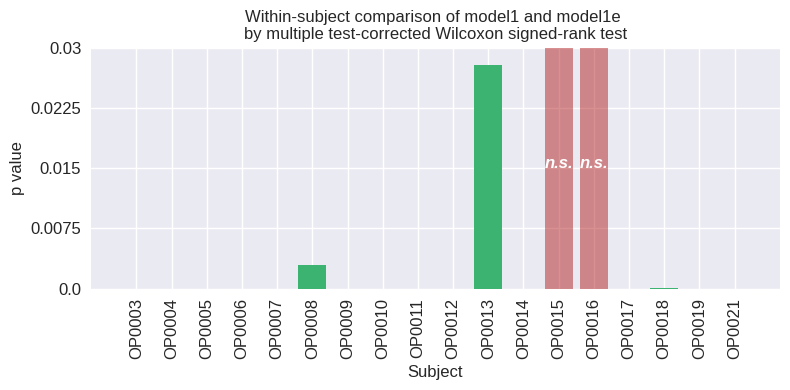

In [13]:
# EMG regress vs no regress
comparison = ['model1', 'model1e']
plt.figure(figsize=(8,4))
modelcomp_pvals = np.zeros((len(subjs)))
for i,s in enumerate(subjs):
    c1 = sig_corrs[comparison[0]][s]
    c2 = sig_corrs[comparison[1]][s]
    stat, modelcomp_pvals[i] = wilcoxon(c1, c2)
    reject, modelcomp_pvals[i], alphacSidak, alphacBonf = multipletests(modelcomp_pvals[i],
                                                                        alpha=0.05,method='fdr_by')
    ylim = [0,0.03]
    if modelcomp_pvals[i] < 0.05:
        color = 'mediumseagreen'
        alpha = 1
    else:
        color = 'firebrick'
        alpha = 0.5
        plt.text(i,np.mean(ylim),'n.s.', ha='center', style='italic',weight='heavy',color='w',fontsize=12)
    plt.bar(i,modelcomp_pvals[i],color=color,alpha=alpha)
plt.gca().set_ylim(ylim)
plt.gca().set_yticks(np.linspace(ylim[0],ylim[1],5))
plt.gca().set_yticklabels(np.linspace(ylim[0],ylim[1],5),fontsize=12)
plt.gca().set_xticks(np.arange(len(subjs)))
plt.gca().set_xticklabels(subjs,rotation='vertical',fontsize=12);
plt.xlabel('Subject',fontsize=12)
plt.ylabel('p value', fontsize=12);
plt.title(f'Within-subject comparison of {comparison[0]} and {comparison[1]} \nby multiple test-corrected Wilcoxon signed-rank test',fontsize=12);
plt.tight_layout();


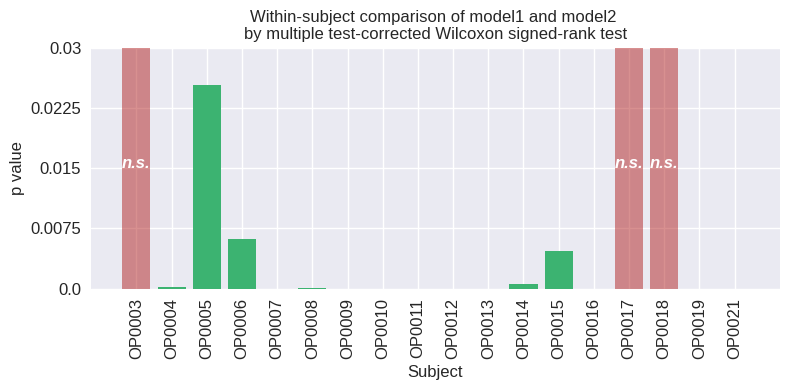

In [14]:
# Identical vs. differential phn feat encoding
comparison = ['model1', 'model2']
plt.figure(figsize=(8,4))
modelcomp_pvals = np.zeros((len(subjs)))
for i,s in enumerate(subjs):
    c1 = sig_corrs[comparison[0]][s]
    c2 = sig_corrs[comparison[1]][s]
    stat, modelcomp_pvals[i] = wilcoxon(c1, c2)
    reject, modelcomp_pvals[i], alphacSidak, alphacBonf = multipletests(modelcomp_pvals[i],
                                                                        alpha=0.05,method='fdr_by')
    ylim = [0,0.03]
    if modelcomp_pvals[i] < 0.05:
        color = 'mediumseagreen'
        alpha = 1
    else:
        color = 'firebrick'
        alpha = 0.5
        plt.text(i,np.mean(ylim),'n.s.', ha='center', style='italic',weight='heavy',color='w',fontsize=12)
    plt.bar(i,modelcomp_pvals[i],color=color,alpha=alpha)
plt.gca().set_ylim(ylim)
plt.gca().set_yticks(np.linspace(ylim[0],ylim[1],5))
plt.gca().set_yticklabels(np.linspace(ylim[0],ylim[1],5),fontsize=12)
plt.gca().set_xticks(np.arange(len(subjs)))
plt.gca().set_xticklabels(subjs,rotation='vertical',fontsize=12);
plt.xlabel('Subject',fontsize=12)
plt.ylabel('p value', fontsize=12);
plt.title(f'Within-subject comparison of {comparison[0]} and {comparison[1]} \nby multiple test-corrected Wilcoxon signed-rank test',fontsize=12);
plt.tight_layout();

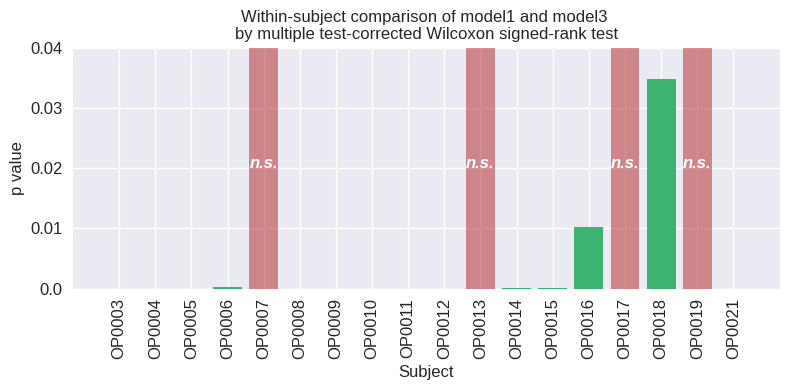

In [15]:
# Encoding vs not encoding task predictability
comparison = ['model1', 'model3']
plt.figure(figsize=(8,4))
modelcomp_pvals = np.zeros((len(subjs)))
for i,s in enumerate(subjs):
    c1 = sig_corrs[comparison[0]][s]
    c2 = sig_corrs[comparison[1]][s]
    stat, modelcomp_pvals[i] = wilcoxon(c1, c2)
    reject, modelcomp_pvals[i], alphacSidak, alphacBonf = multipletests(modelcomp_pvals[i],
                                                                        alpha=0.05,method='fdr_by')
    ylim = [0,0.04]
    if modelcomp_pvals[i] < 0.05:
        color = 'mediumseagreen'
        alpha = 1
    else:
        color = 'firebrick'
        alpha = 0.5
        plt.text(i,np.mean(ylim),'n.s.', ha='center', style='italic',weight='heavy',color='w',fontsize=12)
    plt.bar(i,modelcomp_pvals[i],color=color,alpha=alpha)
plt.gca().set_ylim(ylim)
plt.gca().set_yticks(np.linspace(ylim[0],ylim[1],5))
plt.gca().set_yticklabels(np.linspace(ylim[0],ylim[1],5),fontsize=12)
plt.gca().set_xticks(np.arange(len(subjs)))
plt.gca().set_xticklabels(subjs,rotation='vertical',fontsize=12);
plt.xlabel('Subject',fontsize=12)
plt.ylabel('p value', fontsize=12);
plt.title(f'Within-subject comparison of {comparison[0]} and {comparison[1]} \nby multiple test-corrected Wilcoxon signed-rank test',fontsize=12);
plt.tight_layout();

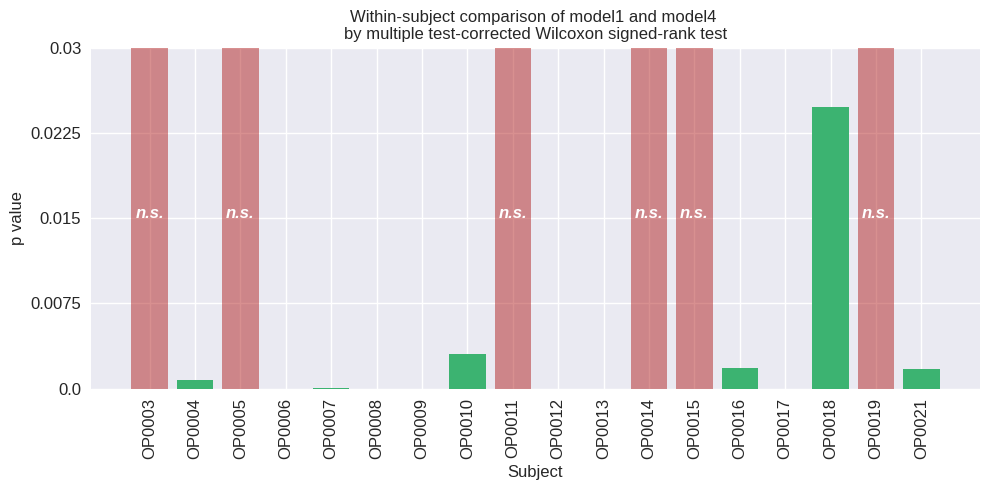

In [16]:
# Encoding vs not encoding task modality
comparison = ['model1', 'model4']
plt.figure(figsize=(10,5))
modelcomp_pvals = np.zeros((len(subjs)))
for i,s in enumerate(subjs):
    c1 = sig_corrs[comparison[0]][s]
    c2 = sig_corrs[comparison[1]][s]
    stat, modelcomp_pvals[i] = wilcoxon(c1, c2)
    reject, modelcomp_pvals[i], alphacSidak, alphacBonf = multipletests(modelcomp_pvals[i],
                                                                        alpha=0.05,method='fdr_by')
    ylim = [0,0.03]
    if modelcomp_pvals[i] < 0.05:
        color = 'mediumseagreen'
        alpha = 1
    else:
        color = 'firebrick'
        alpha = 0.5
        plt.text(i,np.mean(ylim),'n.s.', ha='center', style='italic',weight='heavy',color='w',fontsize=12)
    plt.bar(i,modelcomp_pvals[i],color=color,alpha=alpha)
plt.gca().set_ylim(ylim)
plt.gca().set_yticks(np.linspace(ylim[0],ylim[1],5))
plt.gca().set_yticklabels(np.linspace(ylim[0],ylim[1],5),fontsize=12)
plt.gca().set_xticks(np.arange(len(subjs)))
plt.gca().set_xticklabels(subjs,rotation='vertical',fontsize=12);
plt.xlabel('Subject',fontsize=12)
plt.ylabel('p value', fontsize=12);
plt.title(f'Within-subject comparison of {comparison[0]} and {comparison[1]} \nby multiple test-corrected Wilcoxon signed-rank test',fontsize=12);
plt.tight_layout();